# Project : Spotify Exploratory data analysis (EDA) and Classification
**Group:** Loïc Legroux and Julian Hutin

In this project we will use data obtained from the Spotify API to analyse, visualise and finally make predictions using models trained on the data.

## Preliminary : Import the necessary modules
---



In [1]:
# Imports used in the entire project
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from sklearn import model_selection, svm, tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, root_mean_squared_error
from sklearn.neighbors import NearestNeighbors
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor

warnings.filterwarnings("ignore")

## Exercise 1 : Music genre classification
---

In this exercise the aim is to train a model able to predict the genre of a music from some related data.

For this exercise, two datasets are provided:

- `spotify_dataset_train.csv` containing 25,492 musics belonging to one of the 23 possible genres

- `spotify_dataset_test.csv` containing 2,833 musics for which the genre is not provided and on which our model will make predictions

For ease of use, it was decided to replace the full release date with only the release year.


In [2]:
# We import the training and test datasets
train = pd.read_csv("datasets/spotify_train.csv")
test = pd.read_csv("datasets/spotify_test.csv")

# We only keep the year from the release date
train["release_date"] = train["release_date"].str[:4]
test["release_date"] = test["release_date"].str[:4]

train.head()

,release_date,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,genre
0,2015,False,38,0.509,0.8720,2,-5.170,1,0.0547,0.0396,0.000015,0.3310,0.4860,95.969,194375,4,country
1,2021,False,58,0.182,0.0377,11,-33.748,0,0.0391,0.9870,0.957000,0.0804,0.0923,100.482,241804,4,classical
2,2013,False,36,0.550,0.9410,0,-3.128,0,0.0849,0.0182,0.003750,0.3120,0.3510,145.006,260276,4,rap
3,2012,False,0,0.569,0.7190,6,-8.399,0,0.0663,0.8670,0.941000,0.1760,0.6430,145.118,165200,4,blues
4,2008,False,0,0.631,0.6610,8,-5.694,1,0.0558,0.0146,0.720000,0.3650,0.3300,130.004,245933,4,dance


### A. Data analysis

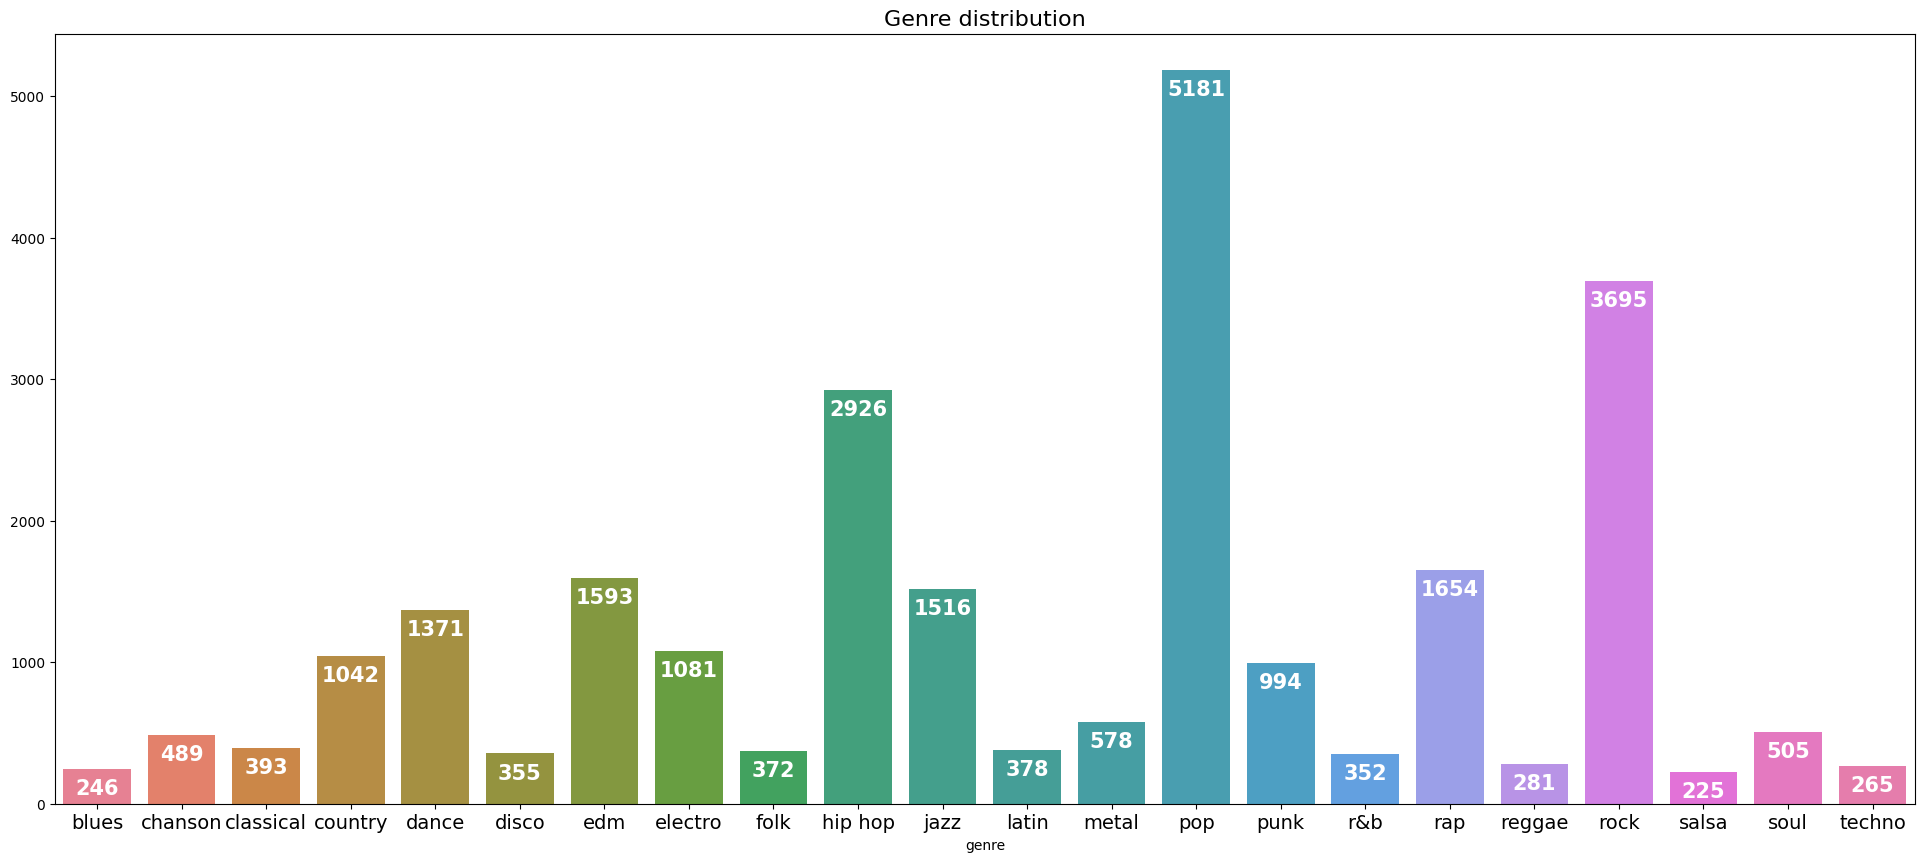

In [3]:
# We look into the distribution of the genres in the dataset
genre_counts = train.groupby("genre")["mode"].count()
plt.figure(figsize=(24, 10))
plt.title("Genre distribution", size=16)
plt.xticks(size=14)

graph = sns.barplot(x=genre_counts.index, y=genre_counts.values, hue=genre_counts.index)

for index, row in enumerate(genre_counts):
    graph.text(index, row - 180, row, color="white", ha="center", size="15", weight="bold")

plt.show()

Not too surprisingly, pop music is the most common.

The distribution of music genres is quite uneven, with the trio **pop / hip hop / rock** accounting for a major part of the data.

This may be problematic for the performance of the model compared to a dataset where all genres would be equally distributed.

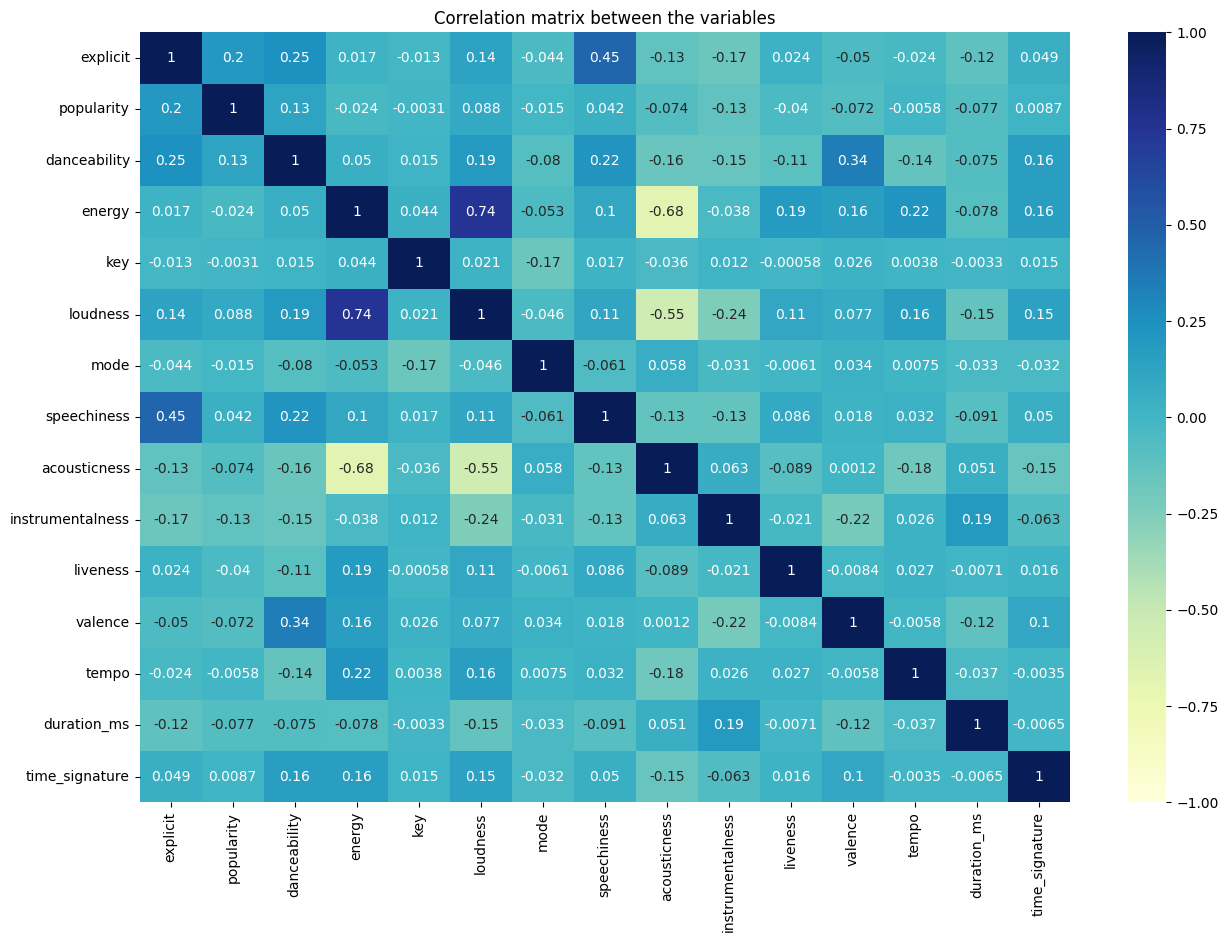

In [4]:
# We check if the variables are correlated with each other
fig, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(train.corr(numeric_only=True), annot=True, cmap="YlGnBu", vmin=-1, vmax=1, center=0, ax=ax)

plt.title("Correlation matrix between the variables")
plt.show()

It can be seen from the correlation matrix above that our variables are fairly uncorrelated with each other, except for a few:

- `loudness` and `energy` are strongly positively correlated, which is consistent: cheerful music is generally loud

- `speechiness` and `explicit` which makes sense because it would be very unusual for an explicit song to have no lyrics

- `danceability` and `valence` the valence variable represents the "cheerful" aspect of a piece of music, it is normal that these two variables are related because people usually dance to cheerful music

There are also two negative correlations:

- `acousticness` and `energy` purely acoustic music is generally calmer compared to music using synthetic instruments

- `acousticness` and `loudness` in a similar manner, basic instruments do not produce excessively loud music

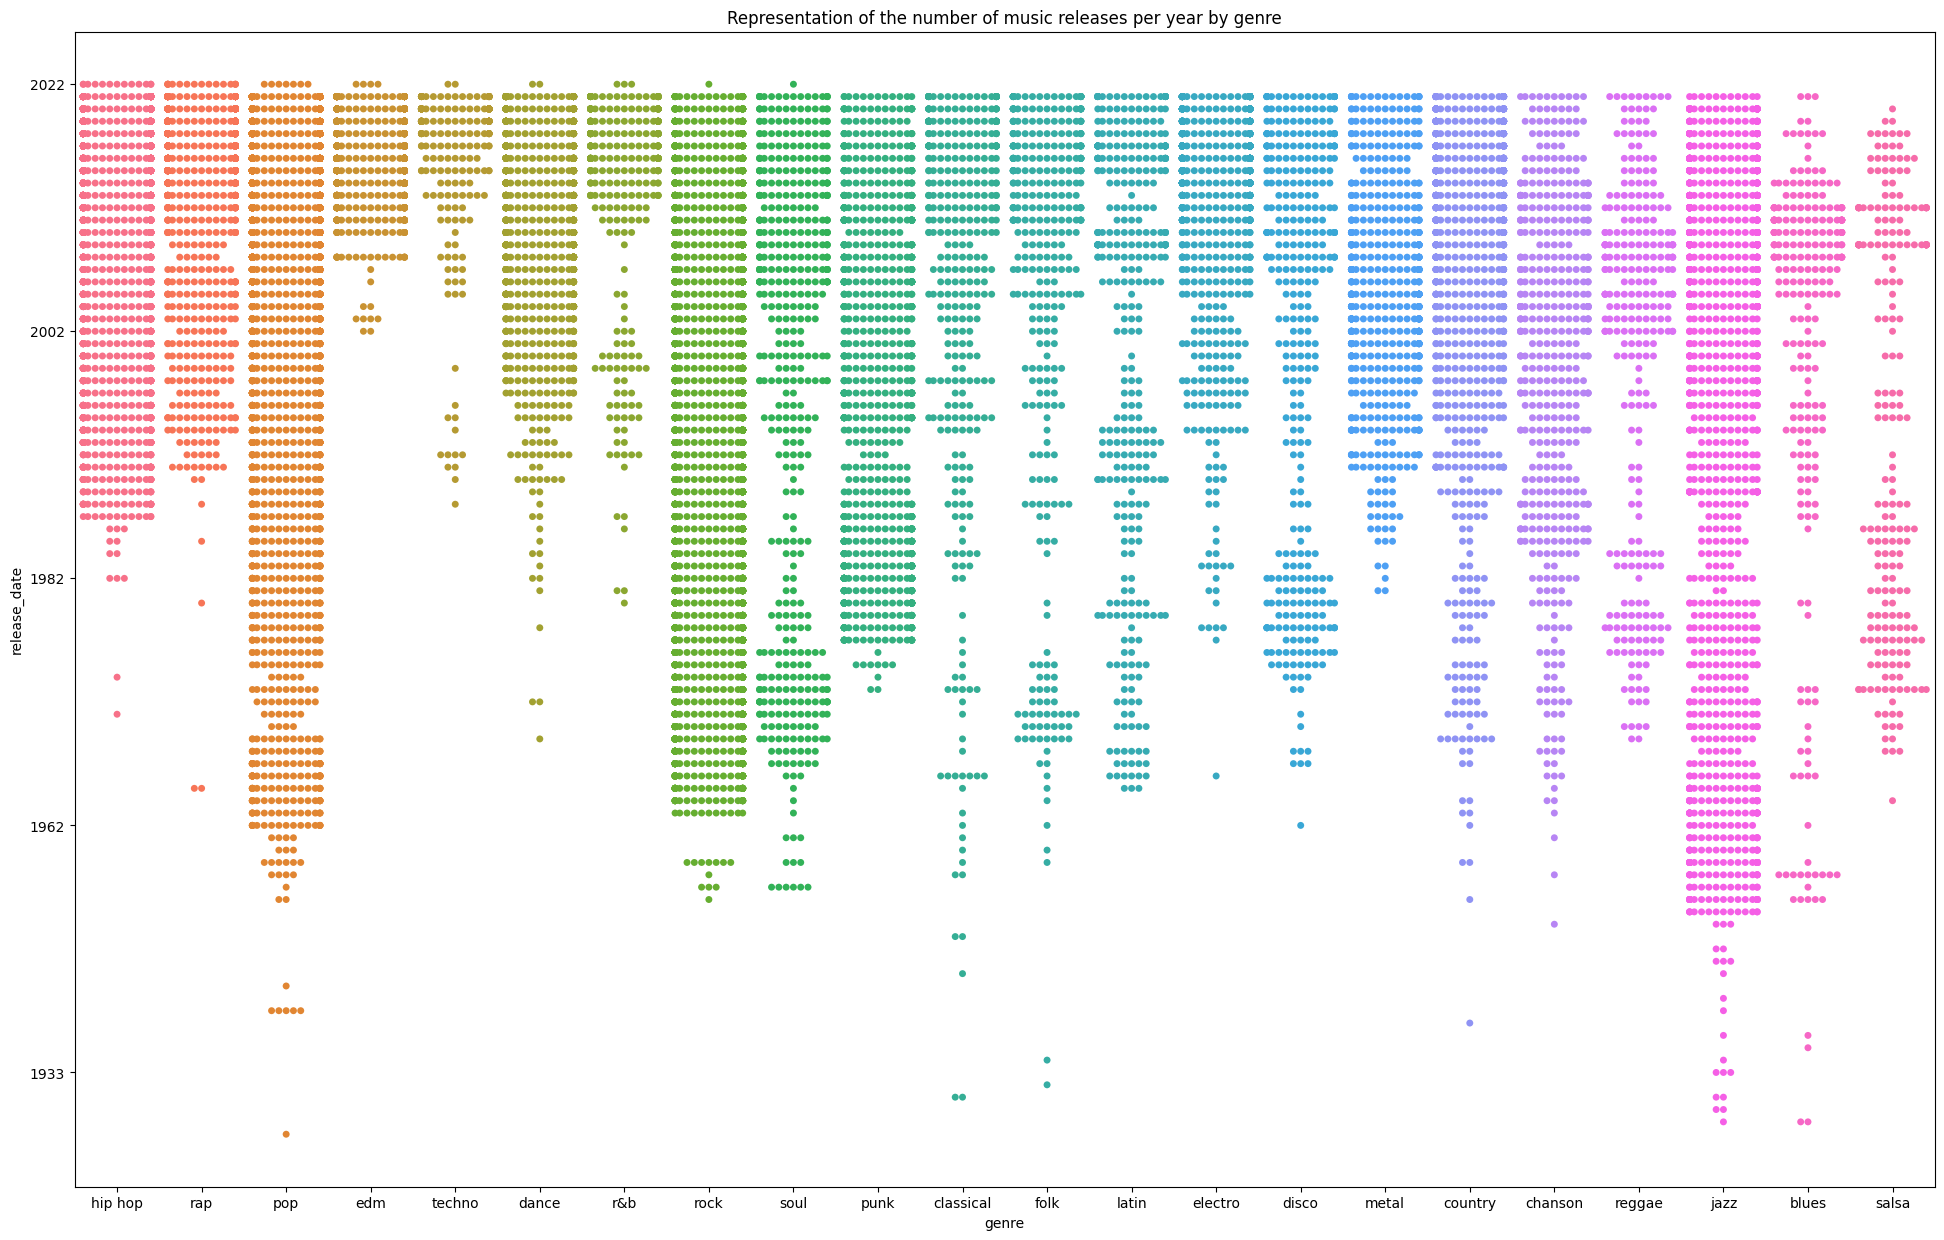

In [5]:
# We use a swarm plot to see the distribution of music by year and genre
plt.figure(figsize=(24, 15))

train = train.sort_values(by=["release_date"], ascending=False)

sns.swarmplot(x=train["genre"], y=train["release_date"], hue=train["genre"])
ax = plt.gca()
# Show a maximum of 5 ticks, prune empty ticks
ax.yaxis.set_major_locator(MaxNLocator(integer=True, prune="both", nbins=6))

plt.title("Representation of the number of music releases per year by genre")
plt.show()

Thanks to the plot above, we have an idea of how many songs are released each year according to their genre.

Each point represents a certain number of songs, so the more points aligned horizontally, the more songs were released during that year.

Although most of the music is quite recent, it is still possible to notice some trends:

- most rap music is recent, which is verified in this graph

- jazz is the genre with the most old music, which is also consistent because it is one of the oldest genres presented here

On the other hand, it is surprising to see that most classical music has been released recently, even though most of it was written a long time ago.

A possible explanation is that the performances back then were obviously not recorded and the release date corresponds to the date the musician who played the scores performed.

<Figure size 2400x1500 with 0 Axes>

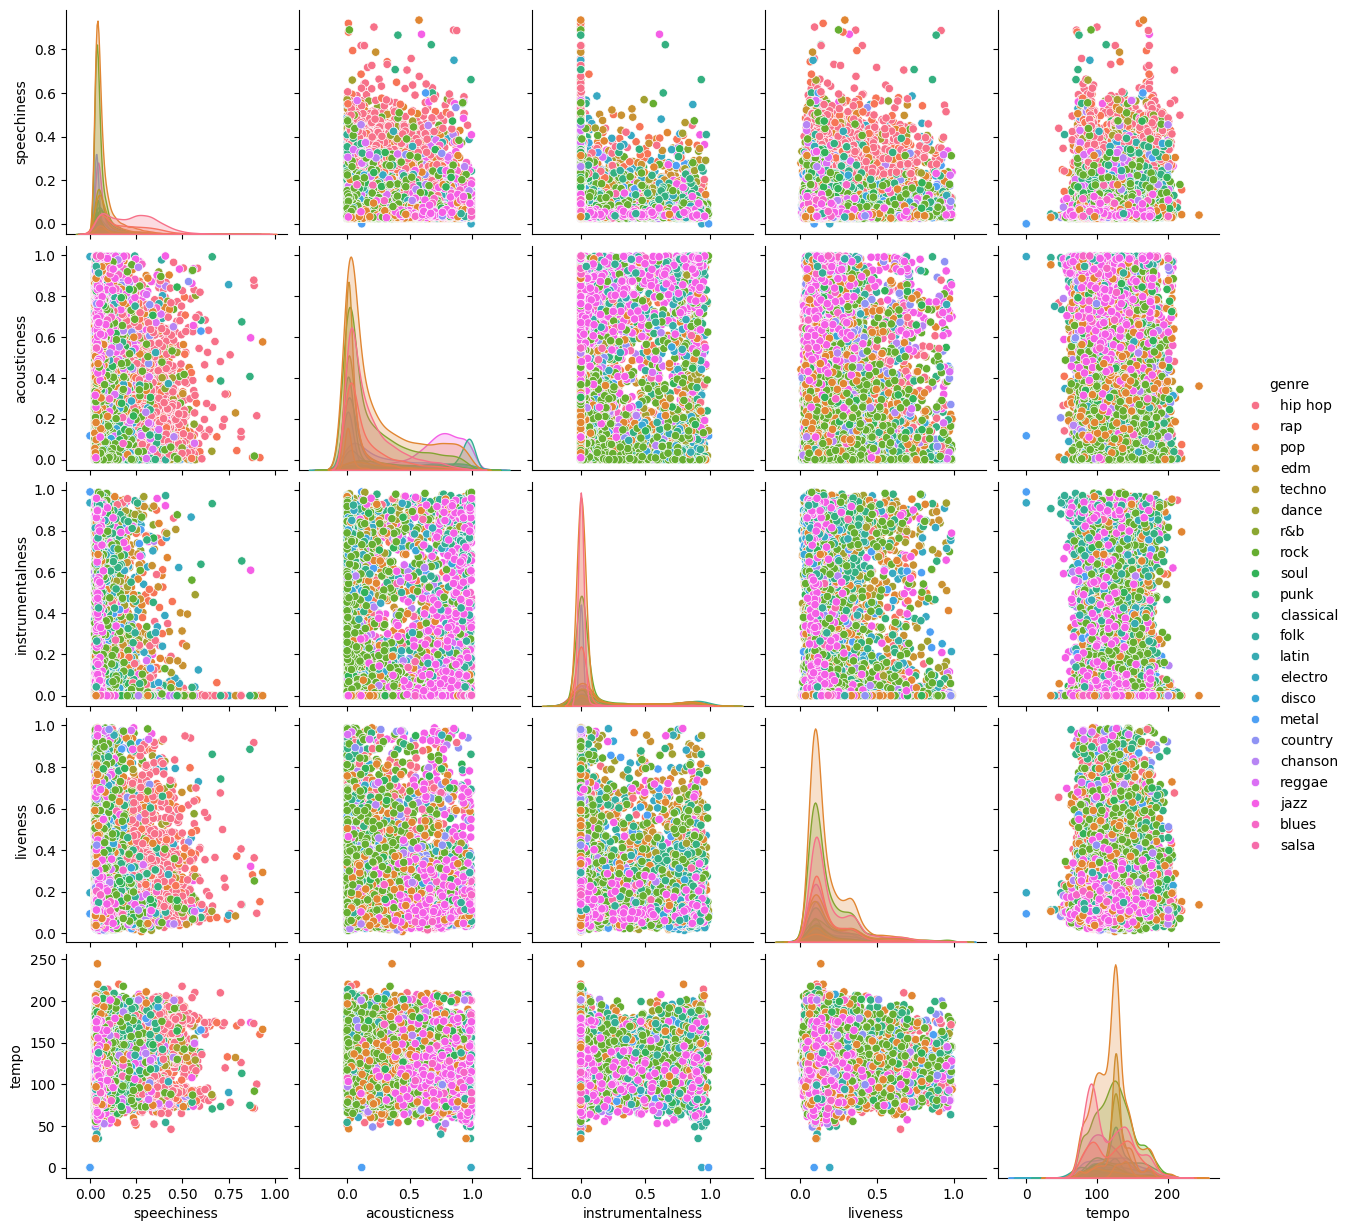

In [6]:
# We remove characteristics that are not purely music related
drops = [
    "release_date",
    "explicit",
    "key",
    "loudness",
    "mode",
    "valence",
    "duration_ms",
    "time_signature",
    "popularity",
    "danceability",
    "energy"
]

spotify_data = train.drop(drops, axis=1)

# We plot the distribution of those variables
plt.figure(figsize=(24, 15))

sns.pairplot(spotify_data, hue="genre")
plt.show()

This graph shows us the distribution of the values taken by the variables of musical type. In spite of the large number of genres, which reduces the readability, we can notice some details:

- a large majority of dance sounds have the same tempo, contrary to other musical styles where the values are more spread out

- in terms of acoustics, jazz and classical music are isolated from the other genres with a distribution centred on much higher values

- in general, the distributions of the genres are centered at the same point but differ in their standard deviations

### B. Data preparation and standardisation

In [7]:
# We clean the data to keep only the important data for classification
# Features that do not provide information on the style of music are removed

train_label = train["genre"]
train_data = train.drop(["genre"], axis=1)

train_data[:10]

,release_date,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
8717,2022,True,39,0.808,0.607,2,-8.327,1,0.3000,0.19100,0.000000,0.1180,0.489,129.974,171183,4
14027,2022,False,28,0.794,0.611,9,-9.672,1,0.4180,0.03310,0.000000,0.3990,0.719,103.885,240000,4
8322,2022,True,43,0.716,0.481,5,-12.204,1,0.3370,0.06630,0.000062,0.0836,0.518,177.041,111408,4
16570,2022,True,59,0.776,0.610,4,-8.508,1,0.0980,0.36300,0.000000,0.1140,0.347,119.968,199955,4
4387,2022,True,44,0.631,0.790,9,-3.968,1,0.3710,0.03000,0.000000,0.1640,0.412,150.080,317727,4
3427,2022,False,45,0.640,0.951,2,-3.376,0,0.0745,0.06110,0.333000,0.2910,0.285,129.982,201231,4
2523,2022,False,30,0.694,0.469,9,-9.688,0,0.3560,0.17800,0.000001,0.1180,0.374,176.056,229564,4
24461,2022,True,59,0.526,0.811,4,-5.619,0,0.3090,0.31300,0.000000,0.3250,0.589,96.381,224093,4
18087,2022,True,81,0.773,0.422,1,-4.572,0,0.1870,0.00783,0.006930,0.1290,0.488,77.502,136267,1
16511,2022,True,0,0.576,0.577,5,-7.111,1,0.4770,0.15900,0.000000,0.2600,0.476,75.961,229938,4


In [8]:
# We extract the list of genres
def get_genres(labels):
    genres = []
    for i in range(len(labels)):
        if labels.values[i] not in genres:
            genres.append(labels.values[i])
    return genres

genres = get_genres(train_label)
print(genres)

['hip hop', 'rap', 'pop', 'edm', 'techno', 'dance', 'r&b', 'rock', 'soul', 'punk', 'classical', 'folk', 'latin', 'electro', 'disco', 'metal', 'country', 'chanson', 'reggae', 'jazz', 'blues', 'salsa']


In [9]:
# We get the name of the features of the dataset
features = train_data.columns

We will now normalise our data, especially those that are not scaled from 0 to 1, so that we can use them as input for our models.

In [10]:
# Training data is normalized from 0 to 1
scaler = MinMaxScaler()

train_data = scaler.fit_transform(train_data)
test_data = scaler.fit_transform(test)

print(train_data)

[[1.         1.         0.39795918 ... 0.53134543 0.0630078  0.8       ]
 [1.         0.         0.28571429 ... 0.42469125 0.0904956  0.8       ]
 [1.         1.         0.43877551 ... 0.72375957 0.03913168 0.8       ]
 ...
 [0.18852459 0.         0.41836735 ... 0.42763876 0.05931305 0.8       ]
 [0.18852459 0.         0.         ... 0.36739666 0.064985   0.8       ]
 [0.         0.         0.         ... 0.39615229 0.05945684 0.8       ]]


In [11]:
# In order to use the classifiers, we transform the labels into numerical values
label_encoder = LabelEncoder()

label_encoder.fit(genres)
true_labels = label_encoder.transform(train_label)

print(true_labels)

[ 9 16  9 ... 10  0 13]


In [12]:
# We split our data into a training set and a testing set
x_train, x_test, y_train, y_test = model_selection.train_test_split(train_data, true_labels)

# On affiche les dimensions des jeux d'entraînement et de test obtenus
print(f"Training set shape: {x_train.shape}")
print(f"Testing set shape: {x_test.shape}")

Training set shape: (19119, 16)
Testing set shape: (6373, 16)


In the following section we will test different models discussed during the SDATA course in order to compare the results.

As instructed in the assignment, the comparison metric used will be the `F1-score` whose expression is the following:

<br>

\begin{equation*}
\mathbf{F}_1 = 
\frac{2\ TP}{2\ TP + FP + FN} 
\end{equation*}

### C. Tested models

#### 1. Linear Discriminant Analysis

In [13]:
classifier_1 = LinearDiscriminantAnalysis(solver="eigen", n_components=2)

classifier_1.fit(x_train, y_train)
y_pred = classifier_1.predict(x_test)

print(f"F1-score = {f1_score(y_test, y_pred, average='micro')}")

F1-score = 0.40294994508080967


#### 2. Decision tree

In [14]:
classifier_2 = tree.DecisionTreeClassifier(criterion="gini", splitter="best", max_depth=7)

classifier_2.fit(x_train, y_train)
y_pred = classifier_2.predict(x_test)

print(f"F1-score = {f1_score(y_test, y_pred, average='micro')}")

F1-score = 0.3971442021026204


#### 3. Support Vector Classification

In [15]:
classifier_3 = svm.SVC(kernel="poly")

classifier_3.fit(x_train, y_train)
y_pred = classifier_3.predict(x_test)

print(f"F1-score = {f1_score(y_test, y_pred, average='micro')}")

F1-score = 0.4335477796955908


#### 4. Multi Layer Perceptron

In [16]:
classifier_4 = MLPClassifier(max_iter=1000)

classifier_4.fit(x_train, y_train)
y_pred = classifier_4.predict(x_test)

print(f"F1-score = {f1_score(y_test, y_pred, average='micro')}")

F1-score = 0.450494272713008


#### 5. Logistic Regression

In [17]:
classifier_5 = LogisticRegression(solver="lbfgs", max_iter=1000)

classifier_5.fit(x_train, y_train)
y_pred = classifier_5.predict(x_test)

print(f"F1-score = {f1_score(y_test, y_pred, average='micro')}")

F1-score = 0.41738584654009103


#### 6. Random Forest

In [18]:
classifier_6 = RandomForestClassifier(n_estimators=2000)

classifier_6.fit(x_train, y_train)
y_pred = classifier_6.predict(x_test)

print(f"F1-score = {f1_score(y_test, y_pred, average='micro')}")

F1-score = 0.4847010826926094


With the F1-score in mind, we will keep the random forest model because it had the best results for this metric.

In order to see how it works in more detail, we will display its confusion matrix as well as the components that have the most influence on this model.

In [19]:
# We print a few predictions
for i in range(10):
    print(f"Truth = {y_test[i]}, Prediction = {y_pred[i]}")

Truth = 20, Prediction = 18
Truth = 18, Prediction = 18
Truth = 13, Prediction = 9
Truth = 16, Prediction = 9
Truth = 8, Prediction = 13
Truth = 21, Prediction = 18
Truth = 13, Prediction = 13
Truth = 5, Prediction = 13
Truth = 20, Prediction = 18
Truth = 18, Prediction = 18


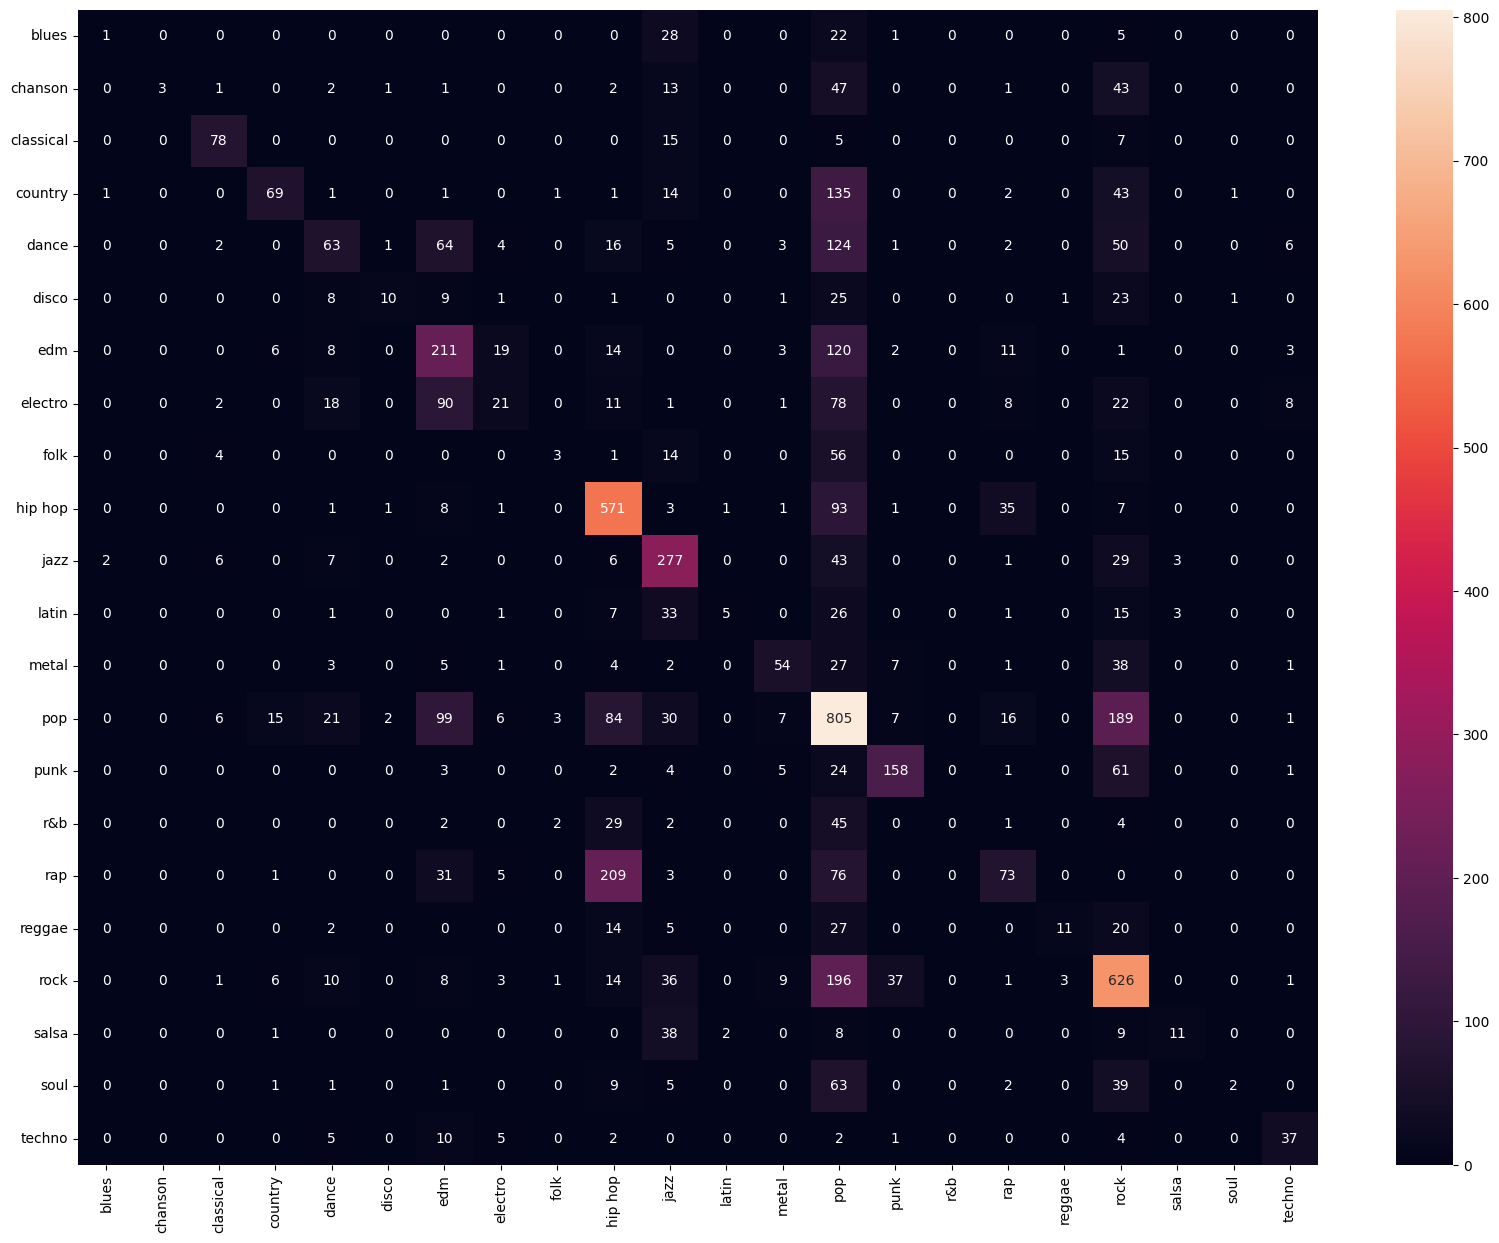

In [20]:
cf_matrix = confusion_matrix(y_test, y_pred)

# We plot the matrix as a heatmap
plt.figure(figsize=(20, 15))

sns.heatmap(cf_matrix, annot=True, fmt="g", xticklabels=sorted(genres), yticklabels=sorted(genres));

The main problem that becomes apparent when looking at the confusion matrix is that many other genres are labeled as "pop".

This can be explained by the fact that pop is by definition a very broad genre and it is possible that our classifier has criteria encompassing a large part of the music for this particular genre.

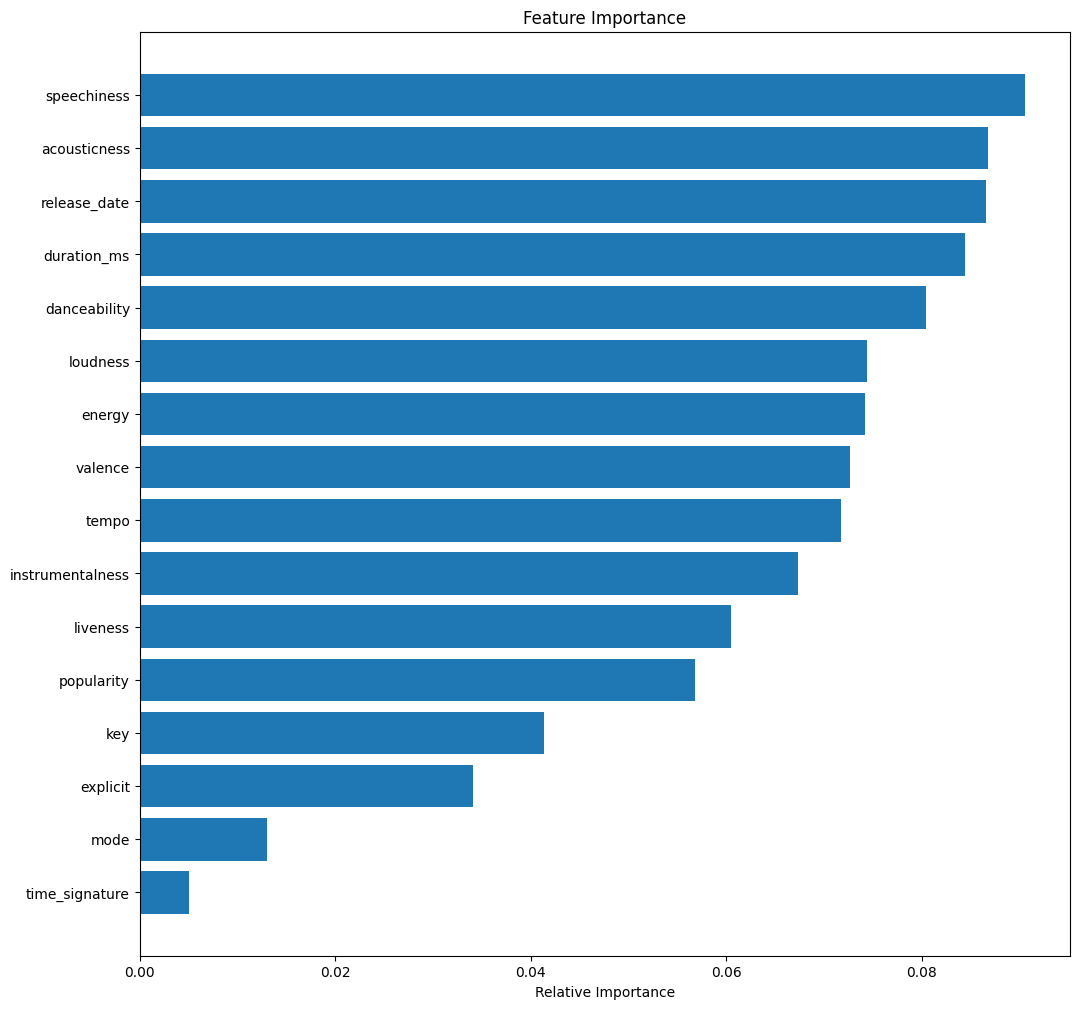

In [21]:
importances = classifier_6.feature_importances_
indexes = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importance")

plt.barh(range(len(indexes)), importances[indexes], align="center")
plt.yticks(range(len(indexes)), features[indexes])
plt.xlabel("Relative Importance");

This graph helps us visualise which criteria are most important for the predictions made by our model:

- as shown by the swarm graph of release years by genre, the date of exit is quite important for the predictions

- we also notice that the duration is a non-negligible criterion, which is surprising because at first glance the duration of a music does not help us guess its genre

In [22]:
predictions = label_encoder.inverse_transform(classifier_6.predict(test))
print(predictions)

['hip hop' 'pop' 'pop' ... 'pop' 'techno' 'jazz']


## Exercise 2 : Popularity prediction
---

### A. Data analysis

In [23]:
data = pd.read_csv("datasets/spotify_subset.csv")
data

,artist_name,track_name,release_date,genres,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature
0,Marry,Vorglühn Nachglühn,2018-10-12,"['discofox', 'partyschlager', 'schlager']",False,42,0.728,0.936,6,-2.557,1,0.1690,0.036800,0.000000,0.3230,0.509,144.968,0lLA33ZtNiWUOB3oATZUbR,174631,4
1,ABBA,Chiquitita,1979,"['europop', 'swedish pop']",False,75,0.500,0.554,9,-8.108,1,0.0354,0.734000,0.000004,0.3120,0.372,84.229,762B4bOcXF7I2Y8UlKTyTy,326320,4
2,Drug Squad,Dangerous Trouble,2010-08-09,['deep punk rock'],False,0,0.149,0.802,1,-9.954,1,0.0465,0.187000,0.785000,0.3560,0.478,185.689,5TeP9dfDZivCzM20ucyHsy,277053,4
3,Ahmad Jamal,Poinciana,1958-05-23,"['bebop', 'cool jazz', 'jazz', 'jazz piano']",False,0,0.604,0.622,9,-9.277,1,0.0282,0.495000,0.661000,0.8730,0.570,97.980,1nTaXD1Kt2qE8Oq92rjdrX,487201,4
4,Korn,Make Me Bad,1999-11-01,"['alternative metal', 'funk metal', 'nu metal'...",True,0,0.527,0.792,11,-6.693,0,0.0363,0.000122,0.037000,0.2490,0.424,110.038,0w6VKmDlUJyIqRcJ6hPwLf,235493,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8693,Yseult,Corps,2019-10-18,"['french indie pop', 'french pop']",False,68,0.501,0.211,5,-11.719,0,0.0386,0.937000,0.000574,0.1020,0.131,77.784,7qx03NsIL42jM03zFphnRO,313184,1
8694,Sheff G,Weight On Me,2020-05-15,"['brooklyn drill', 'new york drill', 'nyc rap']",True,75,0.801,0.533,3,-6.198,0,0.2220,0.707000,0.000043,0.1250,0.626,121.959,6A4hgJdwriera4WSUl4moW,157619,4
8695,Yugo Kanno,il vento d'oro,2018-12-19,"['anime score', 'japanese soundtrack']",False,70,0.491,0.915,11,-4.834,1,0.1430,0.006520,0.125000,0.0906,0.582,134.947,17VP4tofJ3evJbtY8Tk1Qi,295576,4
8696,Anlaya Project,Baltica,2018-05-14,[],False,10,0.637,0.646,1,-9.507,1,0.0703,0.002730,0.025800,0.0737,0.141,128.017,7xbyTxxzmgSthkBfCWuOcJ,512000,4


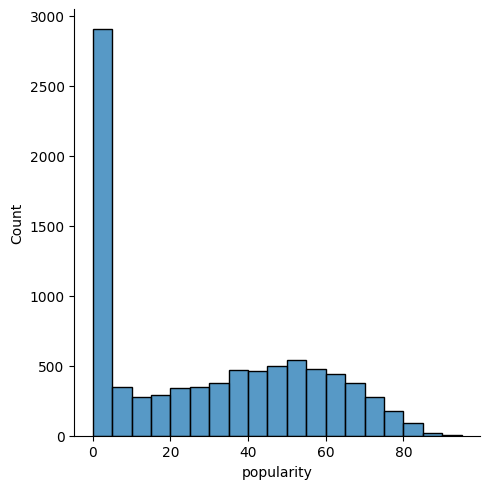

In [24]:
# We display the distribution of popularity
sns.displot(data["popularity"]);

We observe an overrepresentation of the value 0 in the popularity class: it might be a good idea to remove songs with 0 popularity to have a more balanced dataset.

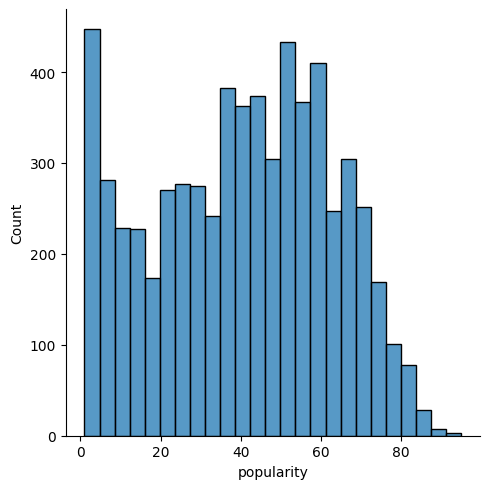

In [25]:
# We do still keep around 500 songs with 0 popularity
k = 3000

for i in range(len(data)):
    if data["popularity"].loc[i] == 0 and k > 500:
        data.drop([i], inplace=True)
        k = k - 1

data.reset_index(drop=True, inplace=True)
sns.displot(data["popularity"]);

The dataset is now more balanced.

We start by removing the artist's name for the sake of simplification, although an artist is obviously responsible for the popularity of a song.

In [26]:
# We only keep the decade corresponding to the release year
data["release_date"] = data["release_date"].str[0:3] + "0"
data["release_date"].astype(int)

# We clean up the data to keep only the important data for classification
# We delete features that do not provide information on the style of the music

data_label = data["popularity"]
train_data = data.drop(["track_name", "id", "popularity", "genres", "artist_name", "time_signature", "mode"], axis=1)

features = train_data.columns
train_data

,release_date,explicit,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,2010,False,0.728,0.936,6,-2.557,0.1690,0.03680,0.000000,0.3230,0.5090,144.968,174631
1,1970,False,0.500,0.554,9,-8.108,0.0354,0.73400,0.000004,0.3120,0.3720,84.229,326320
2,1980,False,0.664,0.613,0,-7.560,0.0273,0.00309,0.000128,0.1750,0.1930,96.600,184587
3,2010,True,0.429,0.964,8,-4.355,0.1150,0.29400,0.094700,0.0330,0.0589,150.038,304072
4,1970,False,0.471,0.770,0,-7.123,0.0935,0.02370,0.000000,0.1660,0.6810,150.920,126907
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6238,2010,False,0.501,0.211,5,-11.719,0.0386,0.93700,0.000574,0.1020,0.1310,77.784,313184
6239,2020,True,0.801,0.533,3,-6.198,0.2220,0.70700,0.000043,0.1250,0.6260,121.959,157619
6240,2010,False,0.491,0.915,11,-4.834,0.1430,0.00652,0.125000,0.0906,0.5820,134.947,295576
6241,2010,False,0.637,0.646,1,-9.507,0.0703,0.00273,0.025800,0.0737,0.1410,128.017,512000


In [27]:
# We normalize the training data from 0 to 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
print(train_data)

[[0.9        0.         0.74666667 ... 0.51991828 0.68032306 0.0919856 ]
 [0.5        0.         0.51282051 ... 0.37997957 0.39527986 0.19593479]
 [0.6        0.         0.68102564 ... 0.19713994 0.45333596 0.09880823]
 ...
 [0.9        0.         0.50358974 ... 0.59448417 0.63329532 0.17486659]
 [0.9        0.         0.65333333 ... 0.14402451 0.60077339 0.32317728]
 [0.9        0.         0.65128205 ... 0.45250255 0.7975334  0.13678156]]


### B. Predictions

In [28]:
# We split our data into a training set and a testing set
x_train, x_test, y_train, y_test = model_selection.train_test_split(train_data, data_label)

print(f"Training set shape: {x_train.shape}")
print(f"Testing set shape: {x_test.shape}")

Training set shape: (4682, 13)
Testing set shape: (1561, 13)


In this exercise we try to predict a popularity value of a music, on a scale from 0 to 100.

We first use a regression tree. 

We will use the RMSE metric to calculate the error of our model.

#### 1. Regression tree

In [29]:
tree = DecisionTreeRegressor()
tree.fit(x_train, y_train)
y_pred = tree.predict(x_test)

print(f"RMSE = {root_mean_squared_error(y_test, y_pred)}")

RMSE = 27.06152384900209


In [30]:
# We print a few predictions
for i in range(10):
    print(f"Truth = {y_test.to_numpy()[i]}, Prediction = {y_pred[i]}")

Truth = 20, Prediction = 64.0
Truth = 7, Prediction = 6.0
Truth = 9, Prediction = 79.0
Truth = 57, Prediction = 38.0
Truth = 58, Prediction = 69.0
Truth = 36, Prediction = 50.0
Truth = 14, Prediction = 27.0
Truth = 83, Prediction = 64.0
Truth = 49, Prediction = 58.0
Truth = 2, Prediction = 62.0


#### 2. Linear regression

In [31]:
reg = LinearRegression()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)

print(f"RMSE = {root_mean_squared_error(y_test, y_pred)}")

RMSE = 21.120121748729836


In [32]:
# We print a few predictions
for i in range(10):
    print(f"Truth = {y_test.to_numpy()[i]}, Prediction = {y_pred[i]}")

Truth = 20, Prediction = 40.53697065458968
Truth = 7, Prediction = 29.65435510234773
Truth = 9, Prediction = 38.92429865763686
Truth = 57, Prediction = 58.259433801423924
Truth = 58, Prediction = 44.198799061920234
Truth = 36, Prediction = 48.44010083059824
Truth = 14, Prediction = 35.08440207680457
Truth = 83, Prediction = 49.46660558132754
Truth = 49, Prediction = 45.136623236738636
Truth = 2, Prediction = 39.77530578978248


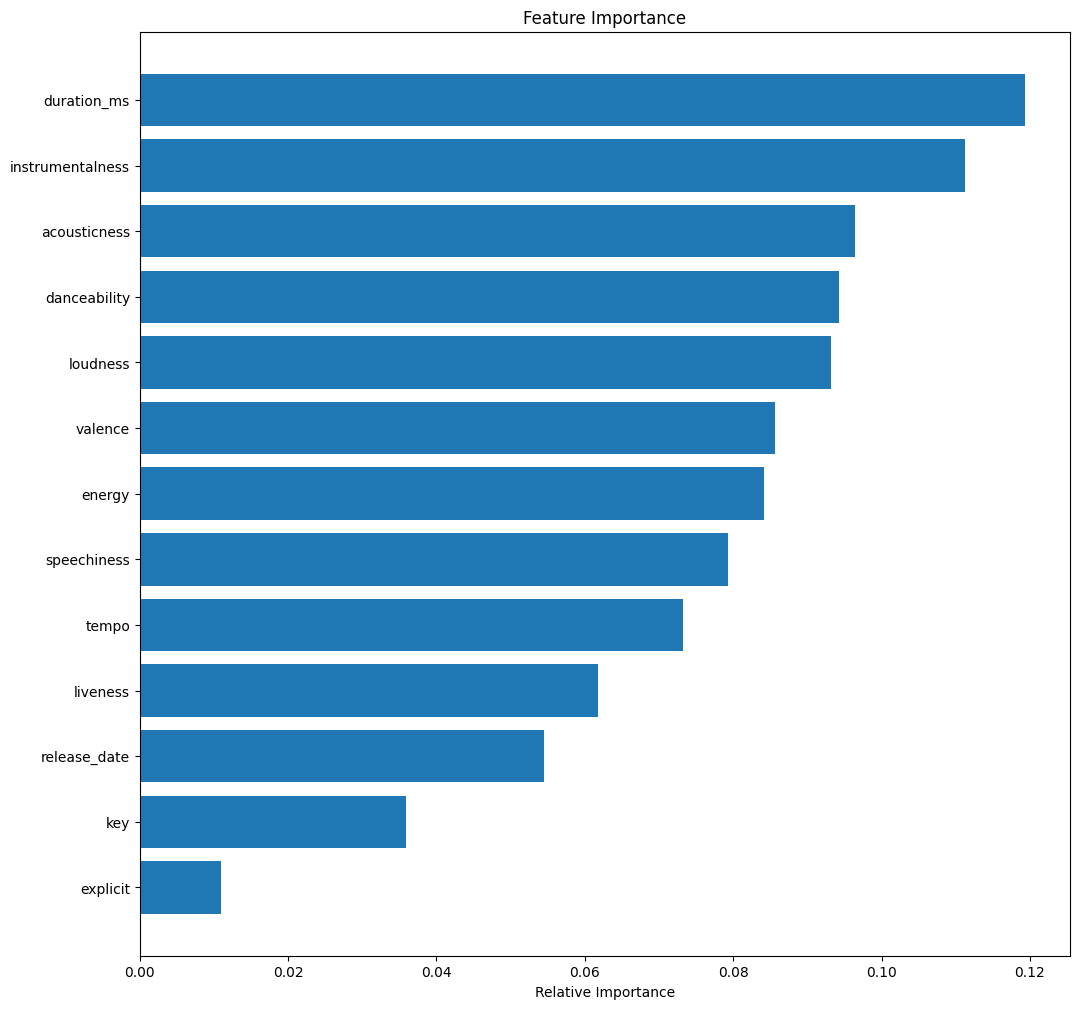

In [33]:
importances = tree.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importance")

plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), features[indices])
plt.xlabel("Relative Importance");

### C. Improvements

#### 1. The `artist_name` is put back into the dataframe as an ID

In [34]:
# We transform each artist into a unique ID
label_encoder = LabelEncoder()
data["artist_name"] = label_encoder.fit_transform(data["artist_name"])

data

,artist_name,track_name,release_date,genres,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature
0,2287,Vorglühn Nachglühn,2010,"['discofox', 'partyschlager', 'schlager']",False,42,0.728,0.936,6,-2.557,1,0.1690,0.03680,0.000000,0.3230,0.5090,144.968,0lLA33ZtNiWUOB3oATZUbR,174631,4
1,46,Chiquitita,1970,"['europop', 'swedish pop']",False,75,0.500,0.554,9,-8.108,1,0.0354,0.73400,0.000004,0.3120,0.3720,84.229,762B4bOcXF7I2Y8UlKTyTy,326320,4
2,1531,Never Tear Us Apart,1980,"['australian rock', 'classic rock', 'dance roc...",False,71,0.664,0.613,0,-7.560,1,0.0273,0.00309,0.000128,0.1750,0.1930,96.600,1GjbTNFImFrjFsNdleDe78,184587,3
3,3247,Necromancy - Original Mix,2010,[],True,2,0.429,0.964,8,-4.355,0,0.1150,0.29400,0.094700,0.0330,0.0589,150.038,2gZ2IyTo7TNZKtMsMvFKCS,304072,4
4,3479,Hate & War - Remastered,1970,"['classic rock', 'permanent wave', 'punk', 'ro...",False,37,0.471,0.770,0,-7.123,1,0.0935,0.02370,0.000000,0.1660,0.6810,150.920,1OtO2g2E1rnAW4KjNNeNui,126907,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6238,4022,Corps,2010,"['french indie pop', 'french pop']",False,68,0.501,0.211,5,-11.719,0,0.0386,0.93700,0.000574,0.1020,0.1310,77.784,7qx03NsIL42jM03zFphnRO,313184,1
6239,3145,Weight On Me,2020,"['brooklyn drill', 'new york drill', 'nyc rap']",True,75,0.801,0.533,3,-6.198,0,0.2220,0.70700,0.000043,0.1250,0.6260,121.959,6A4hgJdwriera4WSUl4moW,157619,4
6240,4025,il vento d'oro,2010,"['anime score', 'japanese soundtrack']",False,70,0.491,0.915,11,-4.834,1,0.1430,0.00652,0.125000,0.0906,0.5820,134.947,17VP4tofJ3evJbtY8Tk1Qi,295576,4
6241,189,Baltica,2010,[],False,10,0.637,0.646,1,-9.507,1,0.0703,0.00273,0.025800,0.0737,0.1410,128.017,7xbyTxxzmgSthkBfCWuOcJ,512000,4


In [35]:
# We drop features we won't be using
train_data = data.drop(["track_name", "id", "popularity", "genres", "time_signature", "mode"], axis=1)

feature = train_data.columns
train_data

,artist_name,release_date,explicit,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,2287,2010,False,0.728,0.936,6,-2.557,0.1690,0.03680,0.000000,0.3230,0.5090,144.968,174631
1,46,1970,False,0.500,0.554,9,-8.108,0.0354,0.73400,0.000004,0.3120,0.3720,84.229,326320
2,1531,1980,False,0.664,0.613,0,-7.560,0.0273,0.00309,0.000128,0.1750,0.1930,96.600,184587
3,3247,2010,True,0.429,0.964,8,-4.355,0.1150,0.29400,0.094700,0.0330,0.0589,150.038,304072
4,3479,1970,False,0.471,0.770,0,-7.123,0.0935,0.02370,0.000000,0.1660,0.6810,150.920,126907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6238,4022,2010,False,0.501,0.211,5,-11.719,0.0386,0.93700,0.000574,0.1020,0.1310,77.784,313184
6239,3145,2020,True,0.801,0.533,3,-6.198,0.2220,0.70700,0.000043,0.1250,0.6260,121.959,157619
6240,4025,2010,False,0.491,0.915,11,-4.834,0.1430,0.00652,0.125000,0.0906,0.5820,134.947,295576
6241,189,2010,False,0.637,0.646,1,-9.507,0.0703,0.00273,0.025800,0.0737,0.1410,128.017,512000


In [36]:
# We normalize the training data from 0 to 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
print(train_data)

[[0.55577157 0.9        0.         ... 0.51991828 0.68032306 0.0919856 ]
 [0.01117861 0.5        0.         ... 0.37997957 0.39527986 0.19593479]
 [0.37205346 0.6        0.         ... 0.19713994 0.45333596 0.09880823]
 ...
 [0.9781288  0.9        0.         ... 0.59448417 0.63329532 0.17486659]
 [0.04592953 0.9        0.         ... 0.14402451 0.60077339 0.32317728]
 [0.49477521 0.9        0.         ... 0.45250255 0.7975334  0.13678156]]


In [37]:
# We split our data into a training set and a testing set
x_train, x_test, y_train, y_test = model_selection.train_test_split(train_data, data_label)

print(f"Training set shape: {x_train.shape}")
print(f"Testing set shape: {x_test.shape}")

Training set shape: (4682, 14)
Testing set shape: (1561, 14)


In [38]:
tree = DecisionTreeRegressor()
tree.fit(x_train, y_train)
y_pred = tree.predict(x_test)

print(f"RMSE = {root_mean_squared_error(y_test, y_pred)}")

RMSE = 27.6975867190204


In [39]:
reg = LinearRegression()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)

print(f"RMSE = {root_mean_squared_error(y_test, y_pred)}")

RMSE = 20.923662216140265


We observe nearly identical performances which is understandable because there are a lot of artists who appear only once therefore it is difficult to make a correlation between an artist and his popularity.

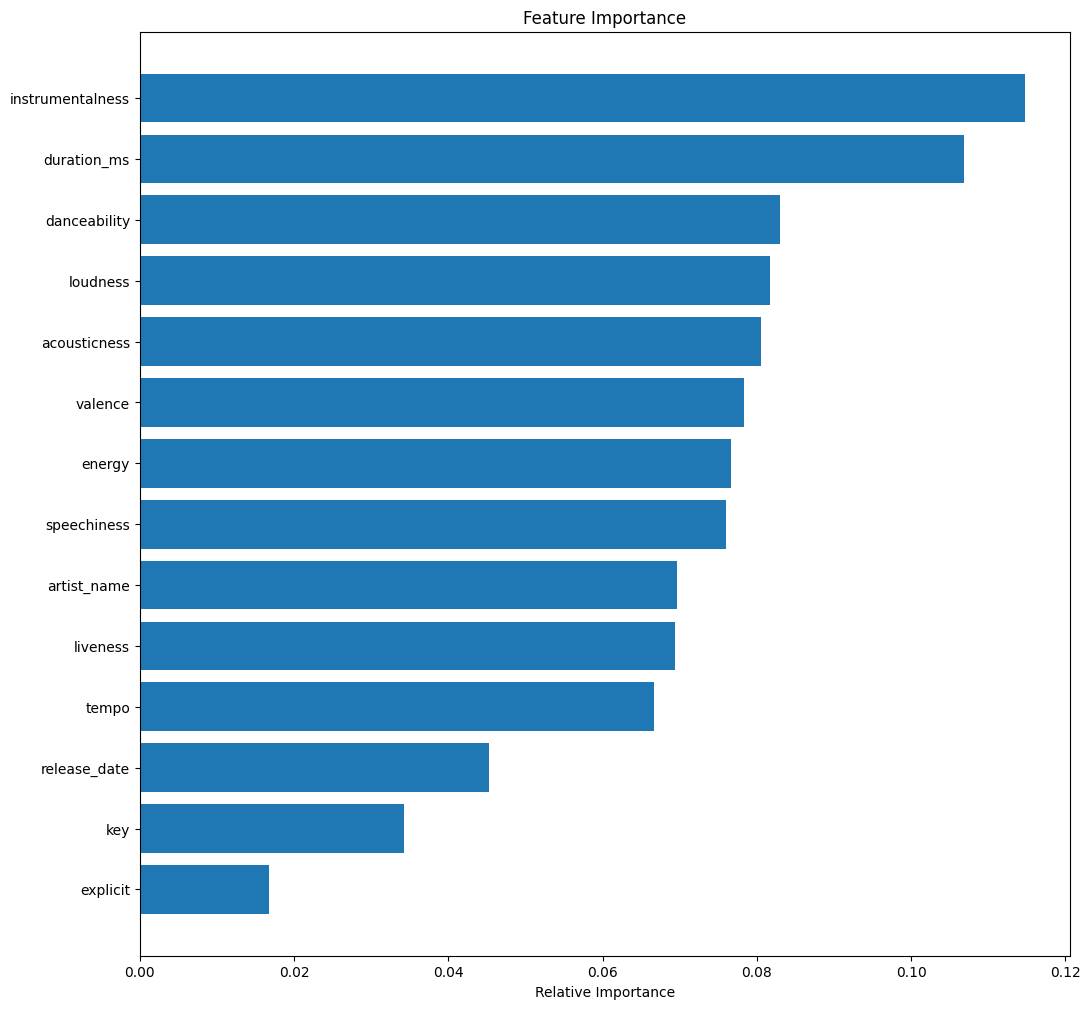

In [40]:
importances = tree.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importance")

plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), feature[indices])
plt.xlabel("Relative Importance");

It is clear that the feature `artist` is not that important after all.

#### 2. Dividing `popularity` into 4 classes

As expected, the accuracy is low because it is difficult to predict popularity exactly on a scale of 0 to 100. It is more relevant to split popularity into 4 classes in order to get better results:

- not popular

- somewhat popular

- popular

- very popular

In [41]:
def popularity_class(popularity: int) -> int:
    if popularity < 25:
        return 1
    elif popularity < 50:
        return 2
    elif popularity < 75:
        return 3
    else:
        return 4

data["popularity"] = data["popularity"].map(popularity_class)

data

,artist_name,track_name,release_date,genres,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature
0,2287,Vorglühn Nachglühn,2010,"['discofox', 'partyschlager', 'schlager']",False,2,0.728,0.936,6,-2.557,1,0.1690,0.03680,0.000000,0.3230,0.5090,144.968,0lLA33ZtNiWUOB3oATZUbR,174631,4
1,46,Chiquitita,1970,"['europop', 'swedish pop']",False,4,0.500,0.554,9,-8.108,1,0.0354,0.73400,0.000004,0.3120,0.3720,84.229,762B4bOcXF7I2Y8UlKTyTy,326320,4
2,1531,Never Tear Us Apart,1980,"['australian rock', 'classic rock', 'dance roc...",False,3,0.664,0.613,0,-7.560,1,0.0273,0.00309,0.000128,0.1750,0.1930,96.600,1GjbTNFImFrjFsNdleDe78,184587,3
3,3247,Necromancy - Original Mix,2010,[],True,1,0.429,0.964,8,-4.355,0,0.1150,0.29400,0.094700,0.0330,0.0589,150.038,2gZ2IyTo7TNZKtMsMvFKCS,304072,4
4,3479,Hate & War - Remastered,1970,"['classic rock', 'permanent wave', 'punk', 'ro...",False,2,0.471,0.770,0,-7.123,1,0.0935,0.02370,0.000000,0.1660,0.6810,150.920,1OtO2g2E1rnAW4KjNNeNui,126907,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6238,4022,Corps,2010,"['french indie pop', 'french pop']",False,3,0.501,0.211,5,-11.719,0,0.0386,0.93700,0.000574,0.1020,0.1310,77.784,7qx03NsIL42jM03zFphnRO,313184,1
6239,3145,Weight On Me,2020,"['brooklyn drill', 'new york drill', 'nyc rap']",True,4,0.801,0.533,3,-6.198,0,0.2220,0.70700,0.000043,0.1250,0.6260,121.959,6A4hgJdwriera4WSUl4moW,157619,4
6240,4025,il vento d'oro,2010,"['anime score', 'japanese soundtrack']",False,3,0.491,0.915,11,-4.834,1,0.1430,0.00652,0.125000,0.0906,0.5820,134.947,17VP4tofJ3evJbtY8Tk1Qi,295576,4
6241,189,Baltica,2010,[],False,1,0.637,0.646,1,-9.507,1,0.0703,0.00273,0.025800,0.0737,0.1410,128.017,7xbyTxxzmgSthkBfCWuOcJ,512000,4


In [42]:
# We drop features we won't be using
data_label = data["popularity"]
train_data = data.drop(["track_name", "id", "popularity", "genres", "artist_name"], axis=1)
train_data

,release_date,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,2010,False,0.728,0.936,6,-2.557,1,0.1690,0.03680,0.000000,0.3230,0.5090,144.968,174631,4
1,1970,False,0.500,0.554,9,-8.108,1,0.0354,0.73400,0.000004,0.3120,0.3720,84.229,326320,4
2,1980,False,0.664,0.613,0,-7.560,1,0.0273,0.00309,0.000128,0.1750,0.1930,96.600,184587,3
3,2010,True,0.429,0.964,8,-4.355,0,0.1150,0.29400,0.094700,0.0330,0.0589,150.038,304072,4
4,1970,False,0.471,0.770,0,-7.123,1,0.0935,0.02370,0.000000,0.1660,0.6810,150.920,126907,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6238,2010,False,0.501,0.211,5,-11.719,0,0.0386,0.93700,0.000574,0.1020,0.1310,77.784,313184,1
6239,2020,True,0.801,0.533,3,-6.198,0,0.2220,0.70700,0.000043,0.1250,0.6260,121.959,157619,4
6240,2010,False,0.491,0.915,11,-4.834,1,0.1430,0.00652,0.125000,0.0906,0.5820,134.947,295576,4
6241,2010,False,0.637,0.646,1,-9.507,1,0.0703,0.00273,0.025800,0.0737,0.1410,128.017,512000,4


In [43]:
# We normalize the training data from 0 to 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
print(train_data)

[[0.9        0.         0.74666667 ... 0.68032306 0.0919856  0.8       ]
 [0.5        0.         0.51282051 ... 0.39527986 0.19593479 0.8       ]
 [0.6        0.         0.68102564 ... 0.45333596 0.09880823 0.6       ]
 ...
 [0.9        0.         0.50358974 ... 0.63329532 0.17486659 0.8       ]
 [0.9        0.         0.65333333 ... 0.60077339 0.32317728 0.8       ]
 [0.9        0.         0.65128205 ... 0.7975334  0.13678156 0.8       ]]


In [44]:
# We split our data into a training set and a testing set
x_train, x_test, y_train, y_test = model_selection.train_test_split(train_data, data_label)

print(f"Training set shape: {x_train.shape}")
print(f"Testing set shape: {x_test.shape}")

Training set shape: (4682, 15)
Testing set shape: (1561, 15)


We are no longer trying to predict a score out of 100 but a class (1, 2, 3 or 4) to quantify popularity.

We will therefore use the `f1-score` metric which is more adapted to the problem.

In [45]:
reg = LogisticRegression()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)

print(f"F1-score = {f1_score(y_test, y_pred, average='micro')}")

F1-score = 0.4228058936579116


In [46]:
# We print a few predictions
for i in range(10):
    print(f"Truth = {y_test.to_numpy()[i]}, Prediction = {y_pred[i]}")

Truth = 2, Prediction = 3
Truth = 3, Prediction = 3
Truth = 1, Prediction = 3
Truth = 1, Prediction = 3
Truth = 1, Prediction = 2
Truth = 3, Prediction = 1
Truth = 1, Prediction = 1
Truth = 1, Prediction = 3
Truth = 4, Prediction = 3
Truth = 3, Prediction = 3


In [47]:
forest = RandomForestClassifier(n_estimators=2000)

forest.fit(x_train, y_train)
y_pred = forest.predict(x_test)

print(f"F1-score = {f1_score(y_test, y_pred, average='micro')}")

F1-score = 0.48110185778347214


In [48]:
# We print a few predictions
for i in range(10):
    print(f"Truth = {y_test.to_numpy()[i]}, Prediction = {y_pred[i]}")

Truth = 2, Prediction = 2
Truth = 3, Prediction = 3
Truth = 1, Prediction = 3
Truth = 1, Prediction = 3
Truth = 1, Prediction = 2
Truth = 3, Prediction = 1
Truth = 1, Prediction = 1
Truth = 1, Prediction = 2
Truth = 4, Prediction = 3
Truth = 3, Prediction = 3


We obtain adequate but still imprecise accuracy scores.

## Exercise 3 : Suggestions and similarity search
---



### A. Music recommendation

The objective of this exercise is to provide recommendations to users based on the music they listen to.

The approach chosen will be to return the 10 closest neighbours of a given piece of music in order to provide a list of recommendations.

In [49]:
# We import the dataset and view some entries
data_recommendations = pd.read_csv("datasets/spotify_recommendation.csv")

data_recommendations.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991000,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.6340,1920
1,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500,1920
2,0.993000,['Mamie Smith'],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.6890,1920
3,0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.997,0.0422,1920
4,0.295000,['Mixe'],0.704,165224,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920


The objective here is to use a similarity search approach, in order to propose a list of 10 suggestions based on the music listened to, we will search for the 10 closest neighbours of the music in question.

Before doing so, it is necessary to prepare the data a little:

- The `id` here doesn't bring much information and is not an indicator of whether two musics are similar or not therefore we will re move it

- Similarly, the `name` is not a real indicator of the music itself and we will also remove it for our search

- The exact `release date` will be abandoned in favour of the exit year, which will be used

- We choose to keep the `popularity` as well as the `release year` as they may be representative of a certain style of music depending on the era or if the listener prefers to listen only to hits or not

- `Duration` will not be kept as it is not generally a criterion that people pay attention to when listening to music

- In the end, we decide not to keep the `artist`, which is a surprising choice because usually the first recommendations give us other music by the same artist


We choose this approach so that users can discover other artists and also for a technical reason: it is complex to find an approach to use these for our K-NN search. Indeed, simply changing each different artist into a numerical value and then normalising would imply that there are similarities between some artists since the distance (Euclidean for our search) would simply depend on their alphabetical order (for a LabelEncoder use). In order to be able to correctly use the artists for this search, it would be necessary to first establish a similarity between artists according to their music.

As for the values we have chosen to keep, most of them are already between 0 and 1 but those that are not will be normalized.

In [50]:
data_prepared = data_recommendations.copy()

# We remove the columns mentioned above
data_prepared.drop(columns=["artists", "duration_ms", "id", "name", "release_date"], inplace=True)

# We normalize the values which are not
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_prepared)

data_scaled = pd.DataFrame(data_scaled, columns=data_prepared.columns, index=data_prepared.index)
data_scaled.head()

,acousticness,danceability,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
0,0.994980,0.605263,0.224,0.0,0.000522,0.454545,0.3790,0.741868,0.0,0.12,0.096395,0.615900,0.6340,0.0
1,0.645582,0.862348,0.517,0.0,0.026400,0.454545,0.0809,0.825918,0.0,0.07,0.054995,0.356823,0.9500,0.0
2,0.996988,0.654858,0.186,0.0,0.000018,0.000000,0.5190,0.750168,1.0,0.04,0.179197,0.400810,0.6890,0.0
3,0.000174,0.738866,0.798,0.0,0.801000,0.181818,0.1280,0.825135,1.0,0.17,0.043769,0.525640,0.0422,0.0
4,0.296185,0.712551,0.707,1.0,0.000246,0.909091,0.4020,0.845102,0.0,0.02,0.079094,0.501324,0.2990,0.0


A K-NN search is now used to return the 10 nearest neighbours:

In [51]:
data_numpy = data_scaled.to_numpy()

KNN = NearestNeighbors(n_neighbors=11, algorithm="ball_tree").fit(data_numpy)

In [52]:
# Let's see the results with a random example
index = 1433

data_recommendations.iloc[index]
distances, indices = KNN.kneighbors(data_numpy[index].reshape(1, -1))

display(data_recommendations.loc[[index], ["artists", "name"]])
recommendation = data_recommendations.loc[indices[0][1:], ["artists", "name"]]
recommendation

,artists,name
1433,"['Orchestre Piero Coppola', 'Piero Coppola']",Carmen : Acte II - Entracte


,artists,name
94476,['Al Bowlly'],"Goodnight, Angel"
60044,"['Samuel Barber', 'Isaac Stern', 'Leonard Bern...","Violin Concerto, Op. 14: II. Andante"
42037,"['Wolfgang Amadeus Mozart', 'Clara Haskil', 'A...",Sonate pour violon et piano No. 32 in B-Flat M...
41936,"['Wolfgang Amadeus Mozart', 'Szymon Goldberg',...","Sonate pour violon et piano No. 17 in C Major,..."
126901,"['Frédéric Chopin', 'Leopold Godowsky']","Nocturne No. 1 in E Minor, Op. 72"
41301,"['Robert Schumann', 'Karl Böhm', 'Staatskapell...","Schumann: Piano Concerto in A Minor, Op. 54: I..."
22250,"['Max Bruch', 'Jascha Heifetz', 'The New Symph...",II. Adagio from Violin Concerto No. 1 in G Min...
41612,"['Felix Mendelssohn', 'Arturo Toscanini']","A Midsummer Night's Dream, Op. 21: Nocturne"
41984,"['Wolfgang Amadeus Mozart', 'Juilliard String ...","Quatuor à cordes No. 19 in C Major, K. 465 ""Le..."
158965,"['Igor Stravinsky', 'Walter Straram Concerts O...",The Firebird: VII Interlude (berceuse)


### B. User feedback

It is possible to extend this method to take into account user feedback.

The concept is that each row is a user and there are as many columns as there are songs in the Spotify database and users can indicate whether they like `(1)` or dislike `(0)` a song.

The diagram below gives an overview of the data:


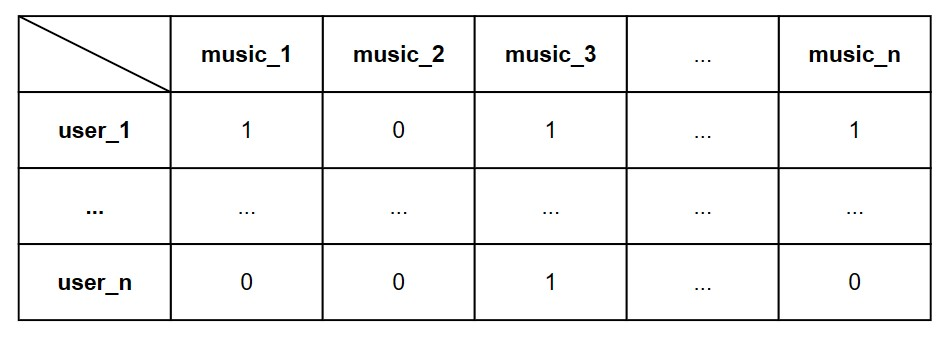

This feedback from users could then be used to find similarities between users. In this case, if a user has very similar tastes to another, it would be wise to suggest music that the other user has enjoyed.